**Aggregation**

Aggregating is the act of collecting something together


Grouping returns a RelationalGroupedDataset on which we specify our aggregations.

***Note*** : When performing calculations over big data, it can be quite expensive to get an exact answer to a question,and it’s often much cheaper to simply request an approximate to a reasonable degree of accuracy.

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("CSV_Read").getOrCreate()

df = spark.read.format("csv")\
 .option("header", "true")\
 .option("inferSchema", "true")\
 .load("/content/online-retail-dataset.csv")\
 .coalesce(5) # controls the no of partitions to 5

df.printSchema()

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/content/online-retail-dataset.csv. SQLSTATE: 42K03

In [ ]:
df.cache()

DataFrame[InvoiceNo: int, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: int, Country: string]

In [ ]:
df.createOrReplaceTempView("dfTable")

In [ ]:
spark.sql("select * from dfTable").show(5)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/01/2010 08:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/01/2010 08:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/01/2010 08:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/01/2010 08:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/01/2010 08:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
only showing top 5 rows


In [ ]:
spark.sql("select distinct InvoiceNo from dfTable where CustomerID=17850").show(5)

+---------+
|InvoiceNo|
+---------+
|   536375|
|   536366|
|   536373|
|   536365|
|   536372|
+---------+
only showing top 5 rows


 **Count**

In [ ]:
df.count()

86

**countDistinct**

In [ ]:
from pyspark.sql.functions import countDistinct
df.select(countDistinct("CustomerID")).show() #

+--------------------------+
|count(DISTINCT CustomerID)|
+--------------------------+
|                         6|
+--------------------------+



**approx_count_distinct**

we find ourselves working with large datasets and the exact distinct count is irrelevant. There are times when an approximation to a certain degree of accuracy will work just fine

In [ ]:
from pyspark.sql.functions import approx_count_distinct

df.select(approx_count_distinct("StockCode", 0.1)).show()
#here 0.1 is maximum estimation error allowed, which means 10%

+--------------------------------+
|approx_count_distinct(StockCode)|
+--------------------------------+
|                              57|
+--------------------------------+



 **first and last**

In [ ]:
from pyspark.sql.functions import first, last

df.select(first("StockCode"), last("StockCode")).show()

+----------------+---------------+
|first(StockCode)|last(StockCode)|
+----------------+---------------+
|          85123A|          22633|
+----------------+---------------+



**min and max**

In [ ]:
from pyspark.sql.functions import min, max

df.select(min("Quantity"), max("Quantity")).show()

+-------------+-------------+
|min(Quantity)|max(Quantity)|
+-------------+-------------+
|            2|           80|
+-------------+-------------+



**sum**

In [ ]:
from pyspark.sql.functions import sum

df.select(sum("Quantity")).show()

+-------------+
|sum(Quantity)|
+-------------+
|         1026|
+-------------+



**sumDistinct**

 sum a distinct set of values

In [ ]:
from pyspark.sql.functions import sumDistinct

df.select(sumDistinct("Quantity")).show()

/usr/local/lib/python3.12/dist-packages/pyspark/sql/functions/builtin.py:1780: FutureWarning: Deprecated in 3.2, use sum_distinct instead.
  warnings.warn("Deprecated in 3.2, use sum_distinct instead.", FutureWarning)


+----------------------+
|sum(DISTINCT Quantity)|
+----------------------+
|                   357|
+----------------------+



**avg**

In [ ]:
from pyspark.sql.functions import count,avg,sum, expr

df.select(
    count("Quantity").alias("total_transactions"),
    sum("Quantity").alias("total_purchases"),
    avg("Quantity").alias("avg_purchases"),
    expr("mean(Quantity)").alias("mean_purchases")).show()


+------------------+---------------+------------------+------------------+
|total_transactions|total_purchases|     avg_purchases|    mean_purchases|
+------------------+---------------+------------------+------------------+
|                86|           1026|11.930232558139535|11.930232558139535|
+------------------+---------------+------------------+------------------+



In [ ]:
df.select(
    count("Quantity").alias("total_transactions"),
    sum("Quantity").alias("total_purchases"),
    avg("Quantity").alias("avg_purchases"),
    expr("mean(Quantity)").alias("mean_purchases"))\
  .selectExpr(
    "total_purchases/total_transactions",
    "avg_purchases",
    "mean_purchases").show()

+--------------------------------------+------------------+------------------+
|(total_purchases / total_transactions)|     avg_purchases|    mean_purchases|
+--------------------------------------+------------------+------------------+
|                    11.930232558139535|11.930232558139535|11.930232558139535|
+--------------------------------------+------------------+------------------+



In [ ]:
df.describe().show()

+-------+------------------+------------------+--------------------+------------------+----------------+------------------+------------------+--------------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|     InvoiceDate|         UnitPrice|        CustomerID|       Country|
+-------+------------------+------------------+--------------------+------------------+----------------+------------------+------------------+--------------+
|  count|                86|                86|                  86|                86|              86|                86|                86|            86|
|   mean| 536370.8720930233|31729.943661971833|                NULL|11.930232558139535|            NULL| 3.520581395348836|           15536.5|          NULL|
| stddev|3.4395502840154215|21277.710932796268|                NULL|13.776186356663285|            NULL|2.7004415127688075|2483.3211289343476|          NULL|
|    min|            536365|             10002| SET 

**Variance and Standard Deviation**

In [ ]:
from pyspark.sql.functions import var_pop, stddev_pop
from pyspark.sql.functions import var_samp, stddev_samp

#pop means population
#samp means sample

df.select(var_pop("Quantity"), var_samp("Quantity"),
stddev_pop("Quantity"), stddev_samp("Quantity")).show()

+------------------+------------------+--------------------+---------------------+
| var_pop(Quantity)|var_samp(Quantity)|stddev_pop(Quantity)|stddev_samp(Quantity)|
+------------------+------------------+--------------------+---------------------+
|187.57652785289338|189.78331053351565|  13.695858054641679|   13.776186356663285|
+------------------+------------------+--------------------+---------------------+



**skewness**

 Skewness measures the asymmetry of the values in your data around the mean


 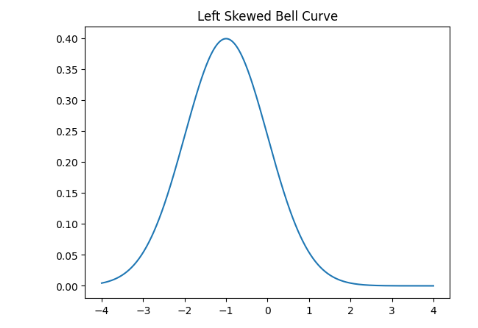

 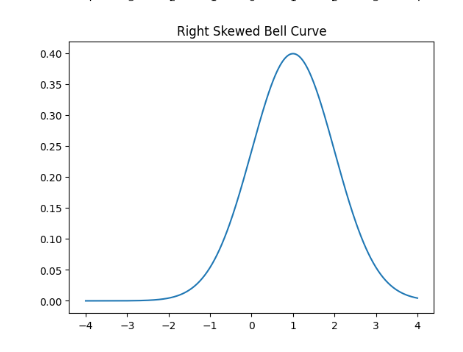

In [ ]:
from pyspark.sql.functions import skewness

df.select(skewness("Quantity")).show()

#Skewness ≈ 0
#Data is symmetrical
#Looks like a normal bell curve
#Left and right tails are balanced

#Skewness = +2.5
#Right-skewed
#Long tail on the right
#Many small values, few very large values

#Skewness = -1.8
#Left-skewed
#Long tail on the left
#Many large values, few very small values

+------------------+
|skewness(Quantity)|
+------------------+
|2.6262845498600083|
+------------------+



**kurtosis**


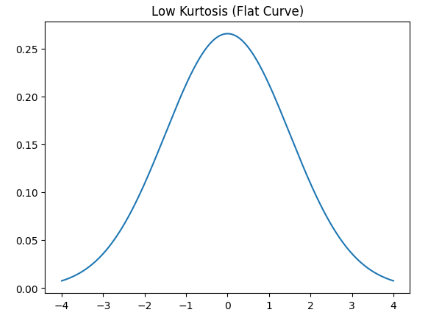


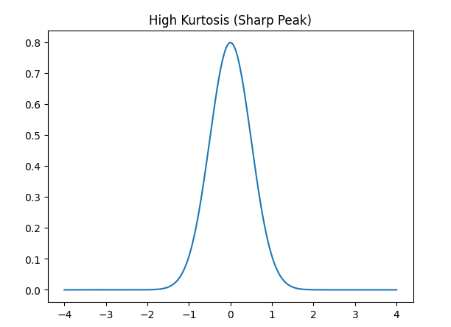

In [ ]:
from pyspark.sql.functions import kurtosis
df.select( kurtosis("Quantity")).show()

#Kurtosis ≈ 0
#Shape is close to a normal bell curve
#Moderate peak
#Normal amount of outliers

#Kurtosis > 0 (High kurtosis)
#Sharp peak
#Heavy tails
#More extreme values (outliers)

#Most orders have very similar quantities
#Few orders have very large quantities (bulk purchases)

#Kurtosis < 0 (Low kurtosis)
#Flat bell curve
#Light tails
#Fewer extreme values



+------------------+
|kurtosis(Quantity)|
+------------------+
| 8.005436432810342|
+------------------+



**Covariance and Correlation**


some functions compare the interactions of the
values in two different columns together.

Correlation measures the Pearson correlation
coefficient, which is scaled between –1 and +1

The covariance is scaled according to the inputs
 in the data.

 **Note** : Variance measures how much a single feature varies from its mean.

 Covariance measures whether two variables increase/decrease together

In [ ]:
from pyspark.sql.functions import corr, covar_pop, covar_samp

df.select(corr("InvoiceNo", "Quantity"), covar_samp("InvoiceNo", "Quantity"),
covar_pop("InvoiceNo", "Quantity")).show()

+-------------------------+-------------------------------+------------------------------+
|corr(InvoiceNo, Quantity)|covar_samp(InvoiceNo, Quantity)|covar_pop(InvoiceNo, Quantity)|
+-------------------------+-------------------------------+------------------------------+
|      0.06634982341183254|             3.1439124484767325|             3.107355326982817|
+-------------------------+-------------------------------+------------------------------+



**Grouping with Expressions**

In [ ]:
from pyspark.sql.functions import count

df.groupBy("InvoiceNo").agg(count("Quantity").alias("quan"),
                    expr("count(Quantity)")).show()

+---------+----+---------------+
|InvoiceNo|quan|count(Quantity)|
+---------+----+---------------+
|   536370|  20|             20|
|   536375|  16|             16|
|   536366|   2|              2|
|   536373|  16|             16|
|   536365|   7|              7|
|   536368|   4|              4|
|   536374|   1|              1|
|   536372|   2|              2|
|   536367|  12|             12|
|   536369|   1|              1|
|   536377|   2|              2|
|   536376|   2|              2|
|   536371|   1|              1|
+---------+----+---------------+



 **Grouping with Maps**

In [ ]:
from pyspark.sql.functions import count,avg,stddev_pop

df.groupBy("InvoiceNo").agg(expr("avg(Quantity)"),expr("stddev_pop(Quantity)")).show()

+---------+-----------------+--------------------+
|InvoiceNo|    avg(Quantity)|stddev_pop(Quantity)|
+---------+-----------------+--------------------+
|   536370|            22.45|   8.935742834258381|
|   536375|              5.5|  1.5000000000000002|
|   536366|              6.0|                 0.0|
|   536373|              5.5|  1.5000000000000002|
|   536365|5.714285714285714|   1.665986255670086|
|   536368|             3.75|   1.299038105676658|
|   536374|             32.0|                 0.0|
|   536372|              6.0|                 0.0|
|   536367|6.916666666666667|   7.750896005552448|
|   536369|              3.0|                 0.0|
|   536377|              6.0|                 0.0|
|   536376|             56.0|                 8.0|
|   536371|             80.0|                 0.0|
+---------+-----------------+--------------------+



**Window Functions**

window functions are used to carry out some unique aggregations on a specific “window” of data

A window function calculates a return value for every input row of a table based on a group of rows, called a frame.

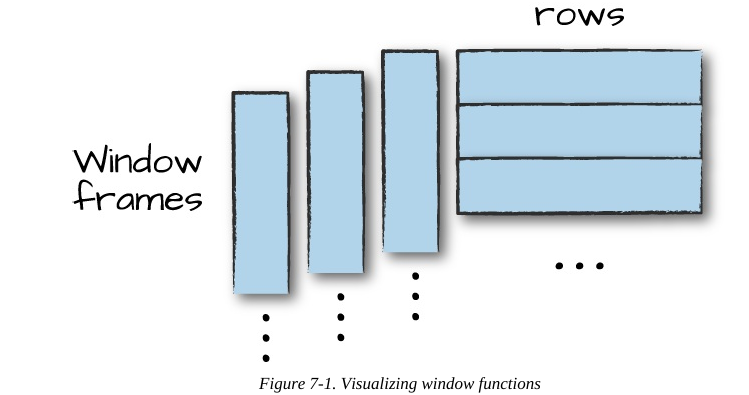

In [ ]:
from pyspark.sql.functions import col, to_date

dfWithDate = df.withColumn("date", to_date(col("InvoiceDate"), "MM/d/yyyy h:mm"))
dfWithDate.createOrReplaceTempView("dfWithDate")

In [ ]:
spark.sql("select * from dfWithDate").show(10)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|      date|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/01/2010 08:26|     2.55|     17850|United Kingdom|2010-12-01|
|   536365|    71053| WHITE METAL LANTERN|       6|12/01/2010 08:26|     3.39|     17850|United Kingdom|2010-12-01|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/01/2010 08:26|     2.75|     17850|United Kingdom|2010-12-01|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/01/2010 08:26|     3.39|     17850|United Kingdom|2010-12-01|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/01/2010 08:26|     3.39|     17850|United Kingdom|2010-12-01|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/01/2010 08:26|    

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import desc

windowSpec = Window.partitionBy("CustomerId", "date")\
                                  .orderBy(desc("Quantity"))\
                                  .rowsBetween(Window.unboundedPreceding, Window.currentRow)

In [ ]:
from pyspark.sql.functions import max

maxPurchaseQuantity = max(col("Quantity")).over(windowSpec)
dfWithDate.withColumn("maxPurchaseQuantity", max(col("Quantity")).over(windowSpec)).show()

+---------+---------+--------------------+--------+----------------+---------+----------+-------+----------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|Country|      date|maxPurchaseQuantity|
+---------+---------+--------------------+--------+----------------+---------+----------+-------+----------+-------------------+
|   536370|    10002|INFLATABLE POLITI...|      48|12/01/2010 08:45|     0.85|     12583| France|2010-12-01|                 48|
|   536370|    22492|MINI PAINT SET VI...|      36|12/01/2010 08:45|     0.65|     12583| France|2010-12-01|                 48|
|   536370|    22728|ALARM CLOCK BAKEL...|      24|12/01/2010 08:45|     3.75|     12583| France|2010-12-01|                 48|
|   536370|    22727|ALARM CLOCK BAKEL...|      24|12/01/2010 08:45|     3.75|     12583| France|2010-12-01|                 48|
|   536370|    21883|    STARS GIFT TAPE |      24|12/01/2010 08:45|     0.65|     12583| France|

In [ ]:
from pyspark.sql.functions import dense_rank, rank

purchaseDenseRank = dense_rank().over(windowSpec)
purchaseRank = rank().over(windowSpec)

In [ ]:
#Now we can perform a select to view the calculated window values:
dfWithDate.where("CustomerId IS NOT NULL").orderBy("CustomerId")\
.select(
  col("CustomerId"),
  col("date"),
  col("Quantity"),
  purchaseRank.alias("quantityRank"),
  purchaseDenseRank.alias("quantityDenseRank"),
  maxPurchaseQuantity.alias("maxPurchaseQuantity")).show()


+----------+----------+--------+------------+-----------------+-------------------+
|CustomerId|      date|Quantity|quantityRank|quantityDenseRank|maxPurchaseQuantity|
+----------+----------+--------+------------+-----------------+-------------------+
|     12583|2010-12-01|      48|           1|                1|                 48|
|     12583|2010-12-01|      36|           2|                2|                 48|
|     12583|2010-12-01|      24|           3|                3|                 48|
|     12583|2010-12-01|      24|           3|                3|                 48|
|     12583|2010-12-01|      24|           3|                3|                 48|
|     12583|2010-12-01|      24|           3|                3|                 48|
|     12583|2010-12-01|      24|           3|                3|                 48|
|     12583|2010-12-01|      24|           3|                3|                 48|
|     12583|2010-12-01|      24|           3|                3|             

In [7]:
from pyspark.sql import functions as F

data = [
    ("StoreA", "2024-01-01", 100),
    ("StoreA", "2024-01-02", 120),
    ("StoreA", "2024-01-03", 90),
    ("StoreA", "2024-01-04", 150),
    ("StoreA", "2024-01-05", 130),
    ("StoreB", "2024-01-01", 200),
    ("StoreB", "2024-01-02", 180),
    ("StoreB", "2024-01-03", 210)
]

dfdata = spark.createDataFrame(data, ["store", "date", "sales"]) \
          .withColumn("date", F.to_date("date"))

dfdata.show()

+------+----------+-----+
| store|      date|sales|
+------+----------+-----+
|StoreA|2024-01-01|  100|
|StoreA|2024-01-02|  120|
|StoreA|2024-01-03|   90|
|StoreA|2024-01-04|  150|
|StoreA|2024-01-05|  130|
|StoreB|2024-01-01|  200|
|StoreB|2024-01-02|  180|
|StoreB|2024-01-03|  210|
+------+----------+-----+



In [8]:
from pyspark.sql.window import Window

window_date = Window.partitionBy("store").orderBy("date")

In [10]:
dfdata.withColumn("prev_day_sales", F.lag("sales", 1).over(window_date)) \
  .withColumn("next_day_sales", F.lead("sales", 1).over(window_date)) \
  .show()

+------+----------+-----+--------------+--------------+
| store|      date|sales|prev_day_sales|next_day_sales|
+------+----------+-----+--------------+--------------+
|StoreA|2024-01-01|  100|          NULL|           120|
|StoreA|2024-01-02|  120|           100|            90|
|StoreA|2024-01-03|   90|           120|           150|
|StoreA|2024-01-04|  150|            90|           130|
|StoreA|2024-01-05|  130|           150|          NULL|
|StoreB|2024-01-01|  200|          NULL|           180|
|StoreB|2024-01-02|  180|           200|           210|
|StoreB|2024-01-03|  210|           180|          NULL|
+------+----------+-----+--------------+--------------+



In [14]:
# Rolling Window (Last 3 Days Moving Average)
rolling_3_days = window_date.rowsBetween(-2, 0)

dfdata.withColumn(
    "moving_avg_3d",
    F.avg("sales").over(rolling_3_days)
).show()

+------+----------+-----+------------------+
| store|      date|sales|     moving_avg_3d|
+------+----------+-----+------------------+
|StoreA|2024-01-01|  100|             100.0|
|StoreA|2024-01-02|  120|             110.0|
|StoreA|2024-01-03|   90|103.33333333333333|
|StoreA|2024-01-04|  150|             120.0|
|StoreA|2024-01-05|  130|123.33333333333333|
|StoreB|2024-01-01|  200|             200.0|
|StoreB|2024-01-02|  180|             190.0|
|StoreB|2024-01-03|  210|196.66666666666666|
+------+----------+-----+------------------+



In [17]:
# TRUE Date-Based Window (Last 3 Days)
df_ts = dfdata.withColumn("date_ts", F.col("date").cast("timestamp"))
df_ts.show()

+------+----------+-----+-------------------+
| store|      date|sales|            date_ts|
+------+----------+-----+-------------------+
|StoreA|2024-01-01|  100|2024-01-01 00:00:00|
|StoreA|2024-01-02|  120|2024-01-02 00:00:00|
|StoreA|2024-01-03|   90|2024-01-03 00:00:00|
|StoreA|2024-01-04|  150|2024-01-04 00:00:00|
|StoreA|2024-01-05|  130|2024-01-05 00:00:00|
|StoreB|2024-01-01|  200|2024-01-01 00:00:00|
|StoreB|2024-01-02|  180|2024-01-02 00:00:00|
|StoreB|2024-01-03|  210|2024-01-03 00:00:00|
+------+----------+-----+-------------------+



In [18]:
date_range_window = Window.partitionBy("store") \
    .orderBy(F.col("date_ts").cast("long")) \
    .rangeBetween(-2 * 86400, 0)   # last 3 days in seconds

In [19]:
df_ts.withColumn(
    "moving_avg_3d_date",
    F.avg("sales").over(date_range_window)
).show()

+------+----------+-----+-------------------+------------------+
| store|      date|sales|            date_ts|moving_avg_3d_date|
+------+----------+-----+-------------------+------------------+
|StoreA|2024-01-01|  100|2024-01-01 00:00:00|             100.0|
|StoreA|2024-01-02|  120|2024-01-02 00:00:00|             110.0|
|StoreA|2024-01-03|   90|2024-01-03 00:00:00|103.33333333333333|
|StoreA|2024-01-04|  150|2024-01-04 00:00:00|             120.0|
|StoreA|2024-01-05|  130|2024-01-05 00:00:00|123.33333333333333|
|StoreB|2024-01-01|  200|2024-01-01 00:00:00|             200.0|
|StoreB|2024-01-02|  180|2024-01-02 00:00:00|             190.0|
|StoreB|2024-01-03|  210|2024-01-03 00:00:00|196.66666666666666|
+------+----------+-----+-------------------+------------------+



In [20]:
# Cumulative Sum (YTD / Running Total)
running_total_window = window_date.rowsBetween(
    Window.unboundedPreceding,
    Window.currentRow
)
aap ko
dfdata.withColumn(
    "running_total",
    F.sum("sales").over(running_total_window)
).show()

+------+----------+-----+-------------+
| store|      date|sales|running_total|
+------+----------+-----+-------------+
|StoreA|2024-01-01|  100|          100|
|StoreA|2024-01-02|  120|          220|
|StoreA|2024-01-03|   90|          310|
|StoreA|2024-01-04|  150|          460|
|StoreA|2024-01-05|  130|          590|
|StoreB|2024-01-01|  200|          200|
|StoreB|2024-01-02|  180|          380|
|StoreB|2024-01-03|  210|          590|
+------+----------+-----+-------------+



**Grouping Sets**

simple group-by expressions that we can use to aggregate on
 a set of columns with the values in those columns.

 sometimes we want something a bit more complete—an aggregation across multiple groups.





In [ ]:
dfNoNull = dfWithDate.drop()
dfNoNull.createOrReplaceTempView("dfNoNull")

In [ ]:
spark.sql("""
SELECT CustomerId, stockCode, sum(Quantity) FROM dfNoNull
GROUP BY customerId, stockCode
ORDER BY CustomerId DESC, stockCode DESC"""
).show()

+----------+---------+-------------+
|CustomerId|stockCode|sum(Quantity)|
+----------+---------+-------------+
|     17850|   85123A|           18|
|     17850|   84406B|           24|
|     17850|   84029G|           18|
|     17850|   84029E|           18|
|     17850|   82494L|           12|
|     17850|    82486|            8|
|     17850|    82483|            4|
|     17850|    82482|           12|
|     17850|    71053|           18|
|     17850|    37370|           12|
|     17850|    22752|            6|
|     17850|    22633|           18|
|     17850|    22632|           18|
|     17850|    21871|           12|
|     17850|    21730|           18|
|     17850|    21071|           12|
|     17850|    21068|           12|
|     17850|    20679|           12|
|     15291|    22114|           48|
|     15291|    21733|           64|
+----------+---------+-------------+
only showing top 20 rows


In [ ]:
spark.sql("""
SELECT CustomerId, stockCode, sum(Quantity) FROM dfNoNull
 GROUP BY customerId, stockCode GROUPING SETS((customerId, stockCode))
 ORDER BY CustomerId DESC, stockCode DESC""").show()

+----------+---------+-------------+
|customerId|stockCode|sum(Quantity)|
+----------+---------+-------------+
|     17850|   85123A|           18|
|     17850|   84406B|           24|
|     17850|   84029G|           18|
|     17850|   84029E|           18|
|     17850|   82494L|           12|
|     17850|    82486|            8|
|     17850|    82483|            4|
|     17850|    82482|           12|
|     17850|    71053|           18|
|     17850|    37370|           12|
|     17850|    22752|            6|
|     17850|    22633|           18|
|     17850|    22632|           18|
|     17850|    21871|           12|
|     17850|    21730|           18|
|     17850|    21071|           12|
|     17850|    21068|           12|
|     17850|    20679|           12|
|     15291|    22114|           48|
|     15291|    21733|           64|
+----------+---------+-------------+
only showing top 20 rows


The GROUPING SETS operator is only available in SQL.

To perform the same in DataFrames, we
 use the rollup and cube operators

**Rollup**

In [24]:
data = [
    ("Asia", "India", 2024, 100),
    ("Asia", "India", 2025, 120),
    ("Asia", "Japan", 2024, 90),
    ("Europe", "Germany", 2024, 80),
    ("Europe", "France", 2025, 70)
]

columns = ["region", "country", "year", "sales"]
dfrollup = spark.createDataFrame(data, columns)
dfrollup.createOrReplaceTempView("sales_table")
dfrollup.show()

+------+-------+----+-----+
|region|country|year|sales|
+------+-------+----+-----+
|  Asia|  India|2024|  100|
|  Asia|  India|2025|  120|
|  Asia|  Japan|2024|   90|
|Europe|Germany|2024|   80|
|Europe| France|2025|   70|
+------+-------+----+-----+



In [25]:
spark.sql("""
SELECT
    region,
    country,
    year,
    SUM(sales) AS total_sales
FROM sales_table
GROUP BY ROLLUP (region, country, year)
ORDER BY region, country, year
"""
).show()

+------+-------+----+-----------+
|region|country|year|total_sales|
+------+-------+----+-----------+
|  NULL|   NULL|NULL|        460|
|  Asia|   NULL|NULL|        310|
|  Asia|  India|NULL|        220|
|  Asia|  India|2024|        100|
|  Asia|  India|2025|        120|
|  Asia|  Japan|NULL|         90|
|  Asia|  Japan|2024|         90|
|Europe|   NULL|NULL|        150|
|Europe| France|NULL|         70|
|Europe| France|2025|         70|
|Europe|Germany|NULL|         80|
|Europe|Germany|2024|         80|
+------+-------+----+-----------+



In [28]:
spark.sql("""
SELECT
    region,
    country,
    year,
    SUM(sales) AS total_sales,
    GROUPING(region)  AS g_region,
    GROUPING(country) AS g_country,
    GROUPING(year)    AS g_year
FROM sales_table
GROUP BY ROLLUP (region, country, year);

""").show()

#0 → column is part of grouping
#1 → column is rolled up (NULL)

+------+-------+----+-----------+--------+---------+------+
|region|country|year|total_sales|g_region|g_country|g_year|
+------+-------+----+-----------+--------+---------+------+
|  NULL|   NULL|NULL|        460|       1|        1|     1|
|  Asia|  India|2025|        120|       0|        0|     0|
|  Asia|  India|NULL|        220|       0|        0|     1|
|  Asia|  India|2024|        100|       0|        0|     0|
|  Asia|   NULL|NULL|        310|       0|        1|     1|
|  Asia|  Japan|2024|         90|       0|        0|     0|
|Europe|Germany|2024|         80|       0|        0|     0|
|Europe|Germany|NULL|         80|       0|        0|     1|
|  Asia|  Japan|NULL|         90|       0|        0|     1|
|Europe| France|2025|         70|       0|        0|     0|
|Europe|   NULL|NULL|        150|       0|        1|     1|
|Europe| France|NULL|         70|       0|        0|     1|
+------+-------+----+-----------+--------+---------+------+



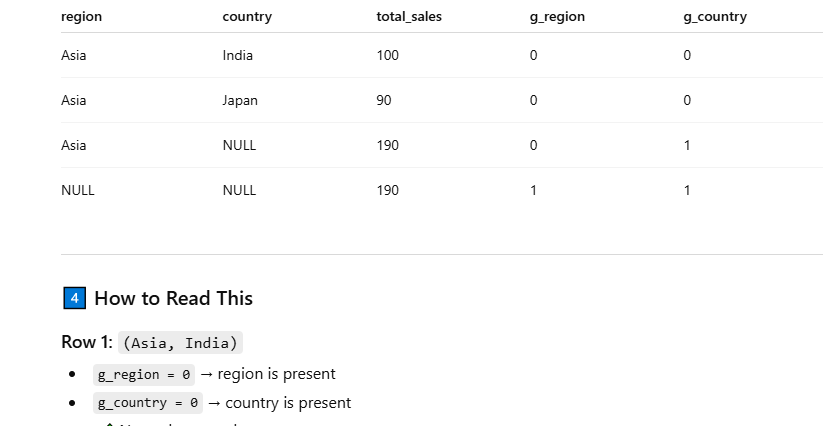

In [29]:
dfrollup.rollup("region", "country", "year") \
  .agg(F.sum("sales").alias("total_sales")) \
  .orderBy("region", "country", "year") \
  .show()

+------+-------+----+-----------+
|region|country|year|total_sales|
+------+-------+----+-----------+
|  NULL|   NULL|NULL|        460|
|  Asia|   NULL|NULL|        310|
|  Asia|  India|NULL|        220|
|  Asia|  India|2024|        100|
|  Asia|  India|2025|        120|
|  Asia|  Japan|NULL|         90|
|  Asia|  Japan|2024|         90|
|Europe|   NULL|NULL|        150|
|Europe| France|NULL|         70|
|Europe| France|2025|         70|
|Europe|Germany|NULL|         80|
|Europe|Germany|2024|         80|
+------+-------+----+-----------+



**Cube**

In [31]:
spark.sql("""
SELECT
    region,
    country,
    year,
    SUM(sales) AS total_sales
FROM sales_table
GROUP BY CUBE (region, country, year)
ORDER BY region, country, year
""").show()

+------+-------+----+-----------+
|region|country|year|total_sales|
+------+-------+----+-----------+
|  NULL|   NULL|NULL|        460|
|  NULL|   NULL|2024|        270|
|  NULL|   NULL|2025|        190|
|  NULL| France|NULL|         70|
|  NULL| France|2025|         70|
|  NULL|Germany|NULL|         80|
|  NULL|Germany|2024|         80|
|  NULL|  India|NULL|        220|
|  NULL|  India|2024|        100|
|  NULL|  India|2025|        120|
|  NULL|  Japan|NULL|         90|
|  NULL|  Japan|2024|         90|
|  Asia|   NULL|NULL|        310|
|  Asia|   NULL|2024|        190|
|  Asia|   NULL|2025|        120|
|  Asia|  India|NULL|        220|
|  Asia|  India|2024|        100|
|  Asia|  India|2025|        120|
|  Asia|  Japan|NULL|         90|
|  Asia|  Japan|2024|         90|
+------+-------+----+-----------+
only showing top 20 rows


For N columns, CUBE produces 2ⁿ grouping combinations.

For (region, country, year) → 8 combinations:

(region, country, year)

(region, country)

(region, year)

(country, year)

(region)

(country)

(year)

() → grand total

In [33]:
dfrollup.cube("region", "country", "year") \
  .agg(F.sum("sales").alias("total_sales")) \
  .orderBy("region", "country", "year") \
  .show()

+------+-------+----+-----------+
|region|country|year|total_sales|
+------+-------+----+-----------+
|  NULL|   NULL|NULL|        460|
|  NULL|   NULL|2024|        270|
|  NULL|   NULL|2025|        190|
|  NULL| France|NULL|         70|
|  NULL| France|2025|         70|
|  NULL|Germany|NULL|         80|
|  NULL|Germany|2024|         80|
|  NULL|  India|NULL|        220|
|  NULL|  India|2024|        100|
|  NULL|  India|2025|        120|
|  NULL|  Japan|NULL|         90|
|  NULL|  Japan|2024|         90|
|  Asia|   NULL|NULL|        310|
|  Asia|   NULL|2024|        190|
|  Asia|   NULL|2025|        120|
|  Asia|  India|NULL|        220|
|  Asia|  India|2024|        100|
|  Asia|  India|2025|        120|
|  Asia|  Japan|NULL|         90|
|  Asia|  Japan|2024|         90|
+------+-------+----+-----------+
only showing top 20 rows


**Pivot**

Pivots make it possible for you to convert a row into a column.

In [42]:

data = [
    ("ProductA", "Jan", 100),
    ("ProductA", "Feb", 120),
    ("ProductA", "Mar", 90),
    ("ProductB", "Jan", 200),
    ("ProductB", "Feb", 180),
    ("ProductB", "Mar", 210)
]

columns = ["product", "month", "sales"]
dfpivot = spark.createDataFrame(data, columns)
dfpivot.createOrReplaceTempView("salespivot_table")

dfpivot.show()

+--------+-----+-----+
| product|month|sales|
+--------+-----+-----+
|ProductA|  Jan|  100|
|ProductA|  Feb|  120|
|ProductA|  Mar|   90|
|ProductB|  Jan|  200|
|ProductB|  Feb|  180|
|ProductB|  Mar|  210|
+--------+-----+-----+



In [36]:
pivot_df = dfpivot.groupBy("product") \
             .pivot("month") \
             .sum("sales")

pivot_df.show()

+--------+---+---+---+
| product|Feb|Jan|Mar|
+--------+---+---+---+
|ProductB|180|200|210|
|ProductA|120|100| 90|
+--------+---+---+---+



In [37]:
pivot_df = dfpivot.groupBy("product") \
             .pivot("month", ["Jan", "Feb", "Mar"]) \
             .agg(F.sum("sales"))

pivot_df.show()

+--------+---+---+---+
| product|Jan|Feb|Mar|
+--------+---+---+---+
|ProductB|200|180|210|
|ProductA|100|120| 90|
+--------+---+---+---+



In [39]:
pivot_df = dfpivot.groupBy("product") \
             .pivot("month") \
             .agg(
                 F.sum("sales").alias("total_sales"),
                 F.avg("sales").alias("avg_sales")
             )

pivot_df.show()

+--------+---------------+-------------+---------------+-------------+---------------+-------------+
| product|Feb_total_sales|Feb_avg_sales|Jan_total_sales|Jan_avg_sales|Mar_total_sales|Mar_avg_sales|
+--------+---------------+-------------+---------------+-------------+---------------+-------------+
|ProductB|            180|        180.0|            200|        200.0|            210|        210.0|
|ProductA|            120|        120.0|            100|        100.0|             90|         90.0|
+--------+---------------+-------------+---------------+-------------+---------------+-------------+



In [43]:
spark.sql("""
SELECT *
FROM (
    SELECT product, month, sales
    FROM salespivot_table
)
PIVOT (
    SUM(sales) FOR month IN ('Jan', 'Feb', 'Mar')
)
""").show()

+--------+---+---+---+
| product|Jan|Feb|Mar|
+--------+---+---+---+
|ProductB|200|180|210|
|ProductA|100|120| 90|
+--------+---+---+---+

